# Preparing Unwrapped, Geocoded Interferograms from GRFN for GIAnT Analysis

In this notebook, we will walk through the various steps involved in importing unwrapped, geocoded interferograms into GIAnT. We will use a Sentinel-1 dataset over Hawaii from the GRFN archive, processed using the ISCE software for this example. 

We will prepare our data assuming the following

1. The geocoded products are not necessarily aligned. We align products on the fly using **GDAL**.

2. The regions of interest and reference point will be provided in map coordinates, allowing us to reuse the data preparation scripts across data from different sources.

But first, we will spend some time exploring the dataset.

# 1. Exploring available data

Let's take a look at the data for the exercise first.

 Let's first change our current working directory to the folder where the data for the tutorial is staged. In my case this is ~/data/giant/kilaeau/2018-unavco-workshop-insar-course. Please use appropriate folder name on your machine.

In [4]:
cd /home/jovyan/work/notebooks/TimeSeries/GRFN

/home/jovyan/work/notebooks/TimeSeries/GRFN


Let's list the contents of the staged directory.

In [5]:
ls

aligned_insar/  Hawaii-download-all-2018-06-15_20-19-13.py
amplitude.kmz   notebook_images/
coastline/      plotts_notebook.ipynb
download/       ProductBoundaries.kml
GIAnT/          VRT/


We will stage the data needed for this tutorial in a folder named **download**. This will contains GRFN data downloaded from the ASF DAAC using the **Hawaii-download-all-2018-06-15_20-19-13.py** python script. The python script was automatically generated by ASF's VERTEX interface. We ran this **download** python script in the download folder to fetch the identified datasets from ASF.

For your convenience, we have added a section to describe the process we used to generate the python script. However, this will not be the focus of the tutorial. We encourage you to take a look at this section at your own convenience. For now, we will copy over the downloaded data to a folder name download.

In [6]:
!cp -r /home/jovyan/course-material/datasets/TimeSeries/GRFN/download .

### Detour: Search process on Vertex for generating download script

The following screen shots show the procedure for searching and setting up the download script on ASF's VERTEX interface. The method presented here works on the current interface. Better search and filtering features are expected to be available in the near future.

#### Step 1: Set up search area and date ranges

![Search Page Screenshot](notebook_images/searchASF.png "ASF Vertex Search Page")

#### Step 2: Search and subset results using text search

ASF Vertex search results show Sentinel-1 SAFE granules as well as the interferograms processed by the GRFN project using ISCE. Currently, the only mechanism available to filter the interferogram products using the Vertex interface is using the filenames. Use key terms like **S1-IFG_RM_M1S1_TN087**, **S1-IFG_RM_M1S2_TN087** and **S1-IFG_RM_M1S3_TN087**. The filenames appear to be related to number of Sentinel-1 SAFE modules that were stitched for the master / slave dates to generate the interferogram.

![Filter Interferograms](notebook_images/filterIFGs.png)

#### Step 3. Walk through search results and add interferogram-coherence products to the queue

One can walk through the search result screen shots on the right and add the products of interest to the download queue. For this example, we only used the **Sentinel-1 Unwrapped Interferogram and Coherence Map (BETA)** products.

![Single Interferogram Product](notebook_images/singleIFG.png)

#### Step 4. Check out the queue and download the python script

Once you have added all the products that you want to the queue, select the **Download Queue** from the top-right section of the Vertex interface and download the python script. 

![Download screen](notebook_images/Download.png)

### Continue exploring data ...

#### List downloaded products

In [7]:
ls download

S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S1_TN087_20180610T161554-20180604T161602_s1-resorb-a8f9-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180517T161552-20180511T161552_s1-resorb-4142-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180529T161553-20180511T161552_s1-resorb-b933-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180529T161553-20180523T161553_s1-resorb-c927-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180604T161637-20180511T161552_s1-resorb-2b7c-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180604T161637-20180523T161553_s1-resorb-1e32-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S2_TN087_20180610T161554-20180523T161553_s1-resorb-1d61-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S3_TN087_20180423T161551-20180411T161459_s1-resorb-be9b-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S3_TN087_20180505T161552-20180411T161459_s1-resorb-9357-v1.2.1-standard.unw_geo.zip*
S1-IFG_RM_M1S3_TN087_20180505T

Looks like **download** subfolder contains each interferogram in its own zipfile with the master and slave dates as part of the file name. 

Data convention from each data source can be different. Follow best practices and always consult documentation for new data sources to confirm details. 

In this case, the dataset was processed using ISCE using the convention highlighted above. Let's look at contents of each interferogram folder

#### List contents of a single product

In [ ]:
!zipinfo -1 download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip

Each folder appears to include a filtered, unwrapped and geocoded interferogram named **filt_topophase.unw.geo** and a corresponding correlation file named **phsig.cor.geo**. These are standard ISCE products. We also corresponding **.vrt** files which will allow us to seamlessly import this data into GIS software. 

The next step is to understand the data layout of each of these products. We will use **gdal** for this.

##### Understand format of unwrapped, geocoded file

In [8]:
!gdalinfo /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/filt_topophase.unw.geo.vrt

Driver: VRT/Virtual Raster
Files: /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/filt_topophase.unw.geo.vrt
       /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/filt_topophase.unw.geo
Size is 4457, 6080
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (-155.627777777777766,20.160000000000000)
Pixel Size = (0.000277777777778,-0.000277777777778)
Corner Coordinates:
Upper Left 

The unwrapped files appear to be 2-band float32 images. We know that the first band of ISCE unwrapped product is the interferogram amplitude and the second band is the unwrapped phase in radians. Note that no NoDataValue is reported for these files.

Packaging of data can vary depending on processing software and the archive. Always consult documentation from each archive.

##### Understand format of coherence file

In [9]:
!gdalinfo /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/phsig.cor.geo.vrt

Driver: VRT/Virtual Raster
Files: /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/phsig.cor.geo.vrt
       /vsizip/download/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard.unw_geo.zip/S1-IFG_RM_M1S1_TN087_20180423T161551-20180330T161523_s1-resorb-73de-v1.2.1-standard/merged/phsig.cor.geo
Size is 4457, 6080
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (-155.627777777777766,20.160000000000000)
Pixel Size = (0.000277777777778,-0.000277777777778)
Corner Coordinates:
Upper Left  (-155.6277778,  2

The coherence files appear to be 1-band float32 images. Note that no NoDataValue is reported for these files.

Packaging of data can vary depending on processing software and the archive. Always consult documentation from each archive.

You will also note that the rasters for the unwrapped phase and the coherence layers in each product are the same size. They may vary from product to product. To check the geospatial extent of each product, we will quickly create a KML file of their bounding boxes.

## 2. Simplification of filenames

But before that we are going to create simpler filenames to work with. We are going to create VRT files in the master**yyyymmdd**-slave**yyyymmdd** format in a new subfolder called "VRT". This intermediate processing step is not needed for many data sources. We choose to use this approach for two reasons:
1. Will make it easier for us to follow the rest of the exercise with simpler filenames.
2. Will allow us to work with the data without having to modify the contents of the downloaded products.
3. Will allow us to assign specific no-data values to the products for automatic handling of missing data by GDAL.

In [19]:
##We will retain downloaded data in zip files for demonstration
import zipfile
import glob
import os
from osgeo import gdal

#Create VRT folder if it doesn't exist
if not os.path.isdir('VRT'):
    os.makedirs('VRT')

##We will now loop over the zip files and create appropriate unw and cor files 
for zz in glob.glob('download/*.zip'):
    ##Get zip file name and construct the unw and cor filenames from it
    basename = os.path.splitext(os.path.splitext(os.path.basename(zz))[0])[0]
    unwsrc =  '/vsizip/' + os.path.join(os.path.abspath(zz), basename, 'merged', 'filt_topophase.unw.geo.vrt')
    corsrc =  '/vsizip/' + os.path.join(os.path.abspath(zz), basename, 'merged', 'phsig.cor.geo.vrt')

    ##Simple string parsing to extract dates from filename
    masterdate = basename.split('-')[1][-15:-7]
    slavedate = basename.split('-')[2][:8]
    
    ##Simplified filenames to work with
    unwdest = os.path.join('VRT', masterdate + '-' + slavedate + '.unw.vrt')
    cordest = os.path.join('VRT', masterdate + '-' + slavedate + '.cor.vrt')
    
    ##Create simple file names - ensuring nodata value is set
    gdal.Translate(unwdest, unwsrc, format='VRT', bandList=[2], noData=0.)
    gdal.Translate(cordest, corsrc, format='VRT', bandList=[1], noData=0.)

###Let's create one amplitude layer for visualization
###We will just use the last unwrapped file for simplicity
ampfile = unwdest.replace('unw', 'amp')
gdal.Translate(ampfile, unwsrc, bandList=[1], noData=0.)

###This is a unix command to build index from list of files
!gdaltindex -f KML ProductBoundaries.kml VRT/*.unw.vrt

File VRT/20180423-20180330.unw.vrt is already in tileindex. Skipping it.
File VRT/20180423-20180411.unw.vrt is already in tileindex. Skipping it.
File VRT/20180505-20180411.unw.vrt is already in tileindex. Skipping it.
File VRT/20180505-20180423.unw.vrt is already in tileindex. Skipping it.
File VRT/20180517-20180423.unw.vrt is already in tileindex. Skipping it.
File VRT/20180517-20180505.unw.vrt is already in tileindex. Skipping it.
File VRT/20180517-20180511.unw.vrt is already in tileindex. Skipping it.
File VRT/20180529-20180505.unw.vrt is already in tileindex. Skipping it.
File VRT/20180529-20180511.unw.vrt is already in tileindex. Skipping it.
File VRT/20180529-20180517.unw.vrt is already in tileindex. Skipping it.
File VRT/20180529-20180523.unw.vrt is already in tileindex. Skipping it.
File VRT/20180604-20180511.unw.vrt is already in tileindex. Skipping it.
File VRT/20180604-20180517.unw.vrt is already in tileindex. Skipping it.
File VRT/20180604-20180523.unw.vrt is already in ti

Open **ProductBoundaries.kml** in Google Earth/QGIS to visualize the spatial extent of each product. Alternately, you can load the KML in python and visualize it as shown below.

In [11]:
###Plotting Product Boundaries on a map
from osgeo import ogr
import numpy as np

driver = ogr.GetDriverByName('KML')  #'ESRI Shapefile' for shapefile
kml_ds = driver.Open('ProductBoundaries.kml')
polys = []

#Iterate over layers
for kml_lyr in kml_ds:
    #Iterate over features
    for feat in kml_lyr:
        geom = feat.GetGeometryRef() #Polygon
        ring = geom.GetGeometryRef(0)  #Ring corresponding to polygon
        poly = np.array([list(x) for x in ring.GetPoints()])        #Points
        polys.append(poly)

kml_ds = None

#Compute limits
maxLat = np.max([np.max(x[:,1]) for x in polys])
minLat = np.min([np.min(x[:,1]) for x in polys])              
maxLon = np.max([np.max(x[:,0]) for x in polys])
minLon = np.min([np.min(x[:,0]) for x in polys])

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


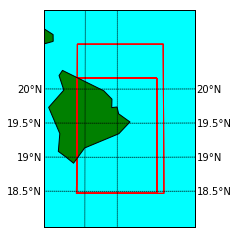

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap            

mmap = Basemap(projection='tmerc', resolution='l',
              llcrnrlon = minLon - 0.5,
              llcrnrlat = minLat - 0.5,
              urcrnrlon = maxLon + 0.5,
              urcrnrlat = maxLat + 0.5,
              lat_0 = 0.5 * (maxLat + minLat),
              lon_0 = 0.5 * (maxLon + minLon ))
mmap.drawmapboundary(fill_color='aqua')
mmap.fillcontinents(color='green', lake_color='aqua')
mmap.drawcoastlines()
pars = np.arange(np.ceil(minLat*2), np.floor(maxLat*2))/2
mmap.drawparallels(pars, labels=[True]*pars.size)
merds = np.arange(np.ceil(minLon*2), np.floor(maxLon*2))/2
mmap.drawmeridians(merds, labels=[True]*merds.size)

###Draw each polygon
for poly in polys:
    nativex, nativey = mmap(poly[:,0], poly[:,1])
    nativepoly = Polygon( list(zip(nativex, nativey)), edgecolor='red', fill=None)
    plt.gca().add_patch(nativepoly)

plt.show()

We can also create a quick view KMZ from the amplitude layer of an interferogram for visualization and to look at the coverage of the radar swath within the geocoded product.

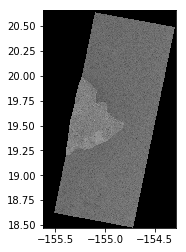

In [13]:
#!gdal_translate -of KMLSUPEROVERLAY -scale -exponent 0.3 -outsize 20% 20% {ampfile} amplitude.kmz -co FORMAT=JPEG
gdal.Translate('amplitude.kmz', ampfile, 
               format='KMLSUPEROVERLAY', exponents=[0.3],
               scaleParams=[''],
               creationOptions=['FORMAT=JPEG'],
               widthPct=20,
               heightPct=20)

###Matplotlib visualization
###Create downlooked file on the fly
ampds = gdal.Translate('', ampfile, 
               format='MEM',
               widthPct=20,
               heightPct=20)
amp = ampds.ReadAsArray()
geoTrans = ampds.GetGeoTransform()
ampds = None
minLon = geoTrans[0]
maxLon = minLon + amp.shape[1] * geoTrans[1]
maxLat = geoTrans[3]
minLat = maxLat + amp.shape[0] * geoTrans[5]

plt.figure()
plt.imshow(amp**0.1,
           extent=[minLon, maxLon, minLat, maxLat],
           cmap='gray')

plt.show()

We are now ready to set up a script that will prepare this dataset for use within GIAnT.

# 2. Setting up a python script for preparing data - prepGIAnT.py

The recommended way to start working with data from a new processor or new source is to create an adapter script called **prepGIAnT.py**. This script is supposed to create input files and input python scripts, which will be then used by GIAnT. 

We will walk through various components of a single script, which we will run stage-by-stage. We will also use python comments within code sections to highlight changes that users can or should make to suit their work. This script is currently setup to work with products generated by GRFN and COMET. One observation is that these projects do not include extensive metadata with their products. We will specifically identify these locations. In future, when metadata is made available by these projects - the scripts should be updated to read in appropriate fields.

## a. Import standard python libraries to work with

In [14]:
#!/usr/bin/env python

import datetime           ##To work with date-time representations
import glob               ##To automatically search directories
from osgeo import gdal    ##To read in geolocation metadata
import os                 ##To create and remove directories
import matplotlib.pyplot as plt  ##Quick plotting
import numpy              ##Matrix calculations

## b. Setup input and output directory names

We have already observed that the input data for this example is already aligned. Nevertheless, we will walk through the process of aligning the different datasets - by subsetting the region covered by the products. Hence, we will setup an input directory named **aligned_insar** which will contain the aligned products.

In [15]:
insarDir  =  './VRT'              ##Directory that contains our interferograms
alignedDir = './aligned_insar'      ##Directory where aligned subsets will be stored
giantDir = './GIAnT'                ##Directory where we will perform the GIAnT analysis

##Check if output directories already exist. If not create them
if not os.path.isdir(alignedDir):
    os.makedirs(alignedDir)
    
if not os.path.isdir(giantDir):
    os.makedirs(giantDir)

## c. Setup region of interest and reference region

For this example, we will process a subset of the data and will use a region of 5 pixels x 5 pixels around a specified point as a reference region for time-series analysis. For subsetting the data, we use **amplitude.kmz** file that is generated above and pick an area around the rift zone.

The final estimated time-series should be interpreted as displacement w.r.t the specified reference region. The reference region is ideally coherent in the interferograms and is assumed to have zero to slow deformation. Local site information is typically needed to select a good reference region.s

The products used in the tutorial are geocode to a Lat/Lon grid
If a UTM / Polar Stereographic grid is used - the regionOfInterest should be specified in the same coordinate system. Alternately, the script should include a section that converts coordinates from one system to another. *pyproj* or *gdal* itself can be used for coordinate transforms.

In [16]:
regionOfInterest = [19.25, 19.7, -155.25, -154.75]   ##SNWE convention from ISCE
refRegionSize    = [5,5]                             ##Reference region size in Lines x Pixels
refRegionCenter  = [19.5457, -155.044]  ###Point in south flank


## d. Utilities to align data and to convert map coordinates to line, pixel

We will now quickly define couple of simple functions which we will use in a loop to map align or subset all the input interferograms.

In [17]:
def stringToDate(instr):
    '''
    This is a simple function that will allow us to convert yyyymmdd to a python datetime object
    '''
    return datetime.datetime.strptime(instr, '%Y%m%d')

def latLonToLinePixel(infile, latlon):
    '''
    This is a simple function that will read in lat, lon coordinates and return corresponding line, pixel
    coordinates in a geocoded file
    '''
    
    ds = gdal.Open(infile, gdal.GA_ReadOnly)  ##Open geocoded file for reading
    trans = ds.GetGeoTransform()              ##Read in the geocoding information
    ds = None                                 ##Closes the file
    ##This is an excerpt from GDAL Documentation (http://www.gdal.org/gdal_tutorial.html)
    ##For Geocoded images that are oriented North Top and West Left
    ##adfGeoTransform[0] /* top left x */
    ##adfGeoTransform[1] /* w-e pixel resolution */ 
    ##adfGeoTransform[2] /* 0 */
    ##adfGeoTransform[3] /* top left y */
    ##adfGeoTransform[4] /* 0 */
    ##adfGeoTransform[5] /* n-s pixel resolution (negative value) */
    
    line = int(np.round((latlon[0] - trans[3])/trans[5]))
    pixel = int(np.round((latlon[1] - trans[0])/trans[1]))
    
    return (line,pixel)


def alignImageToRegion(infile, outfile, snwe, virtual=True, band=1):
    '''
    Align an input image to a specified region (snwe).
    If virtual is False, output is in VRT format which is a simple XML and uses no extra disk space.
    If virtual is True, output is in ENVI binary format which creates new files with subsets.
    Additional options for regridding data, if products are on different grid sizes can also be accommodated.
    '''
    
    ##Pick output format based on virtual flag
    if virtual:
        fmt = 'VRT'
    else:
        fmt = 'ENVI'
    
    ##We are essentially going to run
    # gdal_translate -of fmt -b band -projwin w n e s infile outfile 
    # We are going to do this programmatically instead of making a system call
    
    #Set up options for gdal_translate command
    opts = gdal.TranslateOptions(format=fmt, bandList=[band],
                                 projWin=[snwe[2], snwe[1], snwe[3], snwe[0]])
    #Open input file
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    
    #Translate
    gdal.Translate(outfile, ds, options=opts)
    
    #Close input file
    ds = None

## e. Looping over interferograms and gathering relevant data

We have a very specific type of product for this tutorial. This section will need to be modified for each new source or processor. Always read the documentation to gather the necessary information to make these changes. For our specific case - we can make the following assumptions:

1. Each interferogram subfolder contains one unwrapped file always named **filt_topophase.unw.geo.vrt** and one coherence file named **topophase.cor.geo**.

2. We have unique interferograms - i.e, for a given pair of dates there is only one interferogram. Note that this is particularly an issue when a processing system can generate the same pair with different software version numbers. Based on the documentation from the data source, appropriate changes will need to be made.

In [20]:
##First list all subfolders of insarDir
ifgDirs = glob.glob( insarDir + '/*unw.vrt')
print('Number of identified interferogram folders: {0}'.format(len(ifgDirs)))

###Variable to store interferogram information
ifgList = []
dateList = []

#Loop over interferograms
for ifg in ifgDirs:
    subdirName = os.path.basename(ifg)
    master, slave = subdirName.split('.')[0].split('-')
    
    ###Start gathering data about the pair
    data = {'masterDate' : master,                 ##Master date string
            'slaveDate'  : slave,                  ##Slave date string
            'folder'     : os.path.abspath( os.path.dirname(ifg))} ##Absolute path of folder- could even be URL/S3/zip file
            
    ###At this point, one could load baseline information and sensor information from the product folder
    ###Currently, both GRFN and COMET don't include this information
    ###For our example, we will also assume that this is not available and set it to constants
    data['sensor'] = 'S1'
    data['bperp'] = 0.0
    data['btemp'] = ((stringToDate(master) - stringToDate(slave)).days)
    
    ##Few more fields can be calculated here if necessary - e.g, doppler centroid difference
    
    ##At this stage, we can also add a check to include only certain interferograms for analysis
    ##Say Bperp range, Btemp range, Doppler range, with certain period etc
    ##For now we will assume that we are using all interferograms
    
    if True:   ##True to be replaced with conditionals
        ###Add master and slave to datelist
        dateList.append(master)
        dateList.append(slave)
        
        ifgList.append(data)   ##ifgList will be a list of dictionaries
    
###Determine unique dates
dateList = sorted(list(set(dateList)))
print('Number of unique SAR scenes: {0}'.format(len(dateList)))
print('Number of interferograms retained: {0}'.format(len(ifgList)))

Number of identified interferogram folders: 19
Number of unique SAR scenes: 10
Number of interferograms retained: 19


## f. Some quick summary stats and plots

Number of connected components in interferogram network: 1


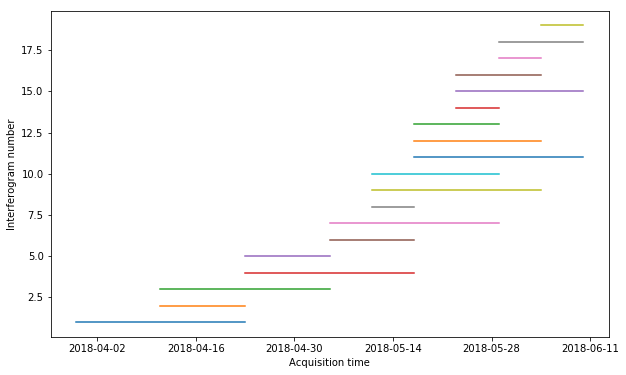

In [21]:
####Quickly ensure that the network is connected
Jmat = np.zeros((len(ifgList), len(dateList)))
for ind, ifg in enumerate(ifgList):
    Jmat[ind, dateList.index( ifg['masterDate'])] = 1
    Jmat[ind, dateList.index( ifg['slaveDate'])] = -1
    
print('Number of connected components in interferogram network: {0}'.format(len(dateList) - numpy.linalg.matrix_rank(Jmat)))


##Sort ifg list by dates. In our case, we have latest date as master consistently
ifgList = sorted(ifgList, key = lambda x: x['slaveDate'])

###Make a quick network coverage plot
plt.figure('Coverage plot', figsize=(10,6))

for ind, ifg in enumerate(ifgList):
    plt.plot([stringToDate(ifg['masterDate']), stringToDate(ifg['slaveDate'])], [ind+1, ind+1])

plt.xlabel('Acquisition time')
plt.ylabel('Interferogram number')
plt.show()   ###Can be replaced with plt.savefig('coverage.pdf', format='pdf')

## g. Aligning or subsetting imagery

In this section we will loop over the interferograms and generate aligned image files. For this tutorial, to save disk space we are going to use virtual files. You can read more about such files here: http://www.gdal.org/gdal_vrttut.html

We assume the following for this tutorial:

1. We will create aligned products in the **aligned_insar** subfolder with the following name scheme - **masteryyyymmdd_slaveyyyymmdd_unw.vrt** for unwrapped phase and ****masteryyyymmdd_slaveyyyymmdd_cor.vrt** for coherence.

2. All the products have the same grid spacing of 1-arc sec. If not, the **alignImageToRegion** function should be modified to take in parameters for common grid spacing as well.

In [22]:
for ifg in ifgList:     ##For each interferogram
    
    ##Align unwrapped phase
    alignImageToRegion( os.path.join(ifg['folder'], ifg['masterDate']+'-'+ifg['slaveDate']+'.unw.vrt'),
                        os.path.join(alignedDir, ifg['masterDate']+'_'+ifg['slaveDate']+'_unw.vrt'),
                        regionOfInterest, band=1)
    
    ##Align coherence
    alignImageToRegion( os.path.join(ifg['folder'], ifg['masterDate']+'-'+ifg['slaveDate']+'.cor.vrt'),
                        os.path.join(alignedDir, ifg['masterDate']+'_'+ifg['slaveDate']+'_cor.vrt'),
                        regionOfInterest, band=1)  

## h. Preparing the interferogram network file - ifg.list

GIAnT uses a simple 4 column text file to communicate the network information. This file will be created within the **GIAnT** folder.

In [23]:
with open( os.path.join('GIAnT', 'ifg.list'), 'w') as fid:
    for ifg in ifgList:
        fid.write('{masterDate}  {slaveDate}  {bperp}  {sensor}\n'.format(**ifg))

## i. Preparing a ROI_PAC rsc file - example.rsc

GIAnT was first developed with ROI_PAC software. The easiest interface to providing some useful metadata to GIAnT is using an rsc file. Here we will build a bare minimum rsc file to use with GIAnT.

In [24]:
##We will use one of the aligned output files to get dimensions
exampleAlignedFile = os.path.join(alignedDir, ifgList[0]['masterDate']+'_'+ifgList[0]['slaveDate']+'_unw.vrt')
ds = gdal.Open( exampleAlignedFile, gdal.GA_ReadOnly)
nLines = ds.RasterYSize
nPixels = ds.RasterXSize

print(nLines, nPixels, 'SIZE')
trans = ds.GetGeoTransform()
ds = None


with open(os.path.join(giantDir, 'example.rsc'), 'w') as fid:
    fid.write('WIDTH     {0}\n'.format(nPixels))
    fid.write('FILE_LENGTH {0}\n'.format(nLines))
    
    ##These fields can be obtained from metadata in each product when available
    fid.write('HEADING_DEG  -12.0 \n')    
    fid.write('WAVELENGTH   0.031228381041666666\n')
    fid.write('CENTER_LINE_UTC   43200\n')

1620 1800 SIZE


## j. Preparing userfn.py to map interferogram dates to files on disk

GIAnT uses a simple user defined function to map dates of SAR acquisitions to interferogram product names on disk. This mechanism allows one to reuse most of the input files and process different versions of the same stack with simple changes to this user defined function.

**userfn.py** takes master date, slave date and sensor name to lookup a database or construct the filenames of the unwrapped phase and coherence products. In our case, these would be the names of the aligned products.

In [25]:
relDir = os.path.relpath(alignedDir, giantDir)
userfnTemplate = """
#!/usr/bin/env python
import os 

def makefnames(dates1, dates2, sensor):
    dirname = '{0}'
    root = os.path.join(dirname, dates1+'_'+dates2)
    unwname = root+'_unw.vrt'
    corname = root+'_cor.vrt'
    return unwname, corname
"""

with open(os.path.join(giantDir, 'userfn.py'), 'w') as fid:
    fid.write(userfnTemplate.format(relDir))


## k. Preparing a water mask (Optional)

This is not always needed for GIAnT. But in our case, we are working with data very close to the coastline and masking out data will significantly speed up the processing. This will also help out with visualization of the time-series outputs.

There are several ways to generate the land water mask using different software (e.g, GMT, GDAL). For our tutorial, we downloaded a high resolution coastline shapefile from the Hawaii State GIS portal: 
http://geoportal.hawaii.gov/datasets/coastline?page=2

We downloaded the coastline shapefile to the **coastline** folder. We will rasterize this shapefile using GDAL.
```bash

wget -O coastline/Coastline.zip  https://opendata.arcgis.com/datasets/045b1d5147634e2380566668e04094c6_3.zip
```
Note that we explicitly call our mask layer - water mask in this example. In reality, you can mask out any parts of your analysis area by providing an appropriate mask file.

For now lets copy over the shapefile from the datasets folder.

In [ ]:
!cp -r /home/jovyan/course-material/datasets/TimeSeries/GRFN/coastline .

In [26]:
ls coastline

Coastline.zip


In [27]:
!zipinfo -1 coastline/Coastline.zip

Coastline.shx
Coastline.cpg
Coastline.prj
Coastline.dbf
Coastline.shp


In [ ]:
!ogrinfo /vsizip/coastline/Coastline.zip/Coastline.shp

INFO: Open of `/vsizip/coastline/Coastline.zip/Coastline.shp'
      using driver `ESRI Shapefile' successful.
1: Coastline (Polygon)


In [ ]:
###Get the extent and spacing to rasterize to using an example aligned raster
exampleAlignedFile = os.path.join(alignedDir, ifgList[0]['masterDate']+'_'+ifgList[0]['slaveDate']+'_unw.vrt')
ds = gdal.Open( exampleAlignedFile, gdal.GA_ReadOnly)

###Read in the coastline file
shapeds = ogr.Open('/vsizip/coastline/Coastline.zip')
layer = shapeds.GetLayerByIndex(0)

##Create output Raster of desired size
driver = gdal.GetDriverByName('MEM')
maskds = driver.Create( '',
                        ds.RasterXSize,
                        ds.RasterYSize,
                        1, gdal.GDT_Byte)
maskds.SetProjection(ds.GetProjectionRef())
maskds.SetGeoTransform(ds.GetGeoTransform())
band = maskds.GetRasterBand(1)
band.Fill(0)

gdal.RasterizeLayer(maskds,  # output to our new dataset
                    [1],  # output to our new dataset's first band
                    layer,  # rasterize this layer
                    None, None,  # don't worry about transformations since we're in same projection
                    [1])  # burn value 1

img = maskds.ReadAsArray()
geoTrans = maskds.GetGeoTransform()

ds = None
shapeds = None
maskds = None

###Write water mask to GIAnT Directory
img.astype(np.float32).tofile(os.path.join(giantDir, 'watermask.flt'))                            
minLon = geoTrans[0]
maxLon = minLon + img.shape[1] * geoTrans[1]
maxLat = geoTrans[3]
minLat = maxLat + img.shape[0] * geoTrans[5]
plt.figure()
plt.imshow(img, extent=[minLon, maxLon, minLat, maxLat], cmap='gray')
plt.show()


## l. Preparing prepdataxml.py

**prepdataxml.py** is a user defined function that is used to communicate some data pre-processing parameters and format information to GIAnT. The method is extensively documented in the user manual. For this tutorial, we will perform a simple setup.

In [ ]:
prepdataTemplate = """
#!/usr/bin/env python

import tsinsar as ts
import argparse
import numpy as np

if __name__ == '__main__':

    ######Prepare the data.xml
    g = ts.TSXML('data')
    g.prepare_data_xml('example.rsc', proc='RPAC',
                       xlim=[0,{0}], ylim=[0, {1}],        ##Assuming no cropping
                       rxlim = [{2},{3}], rylim=[{4},{5}], ##Reference region 
                       latfile='', lonfile='', hgtfile='', ##Needed only for tropospheric corrections
                       inc = 21., cohth=0.3, chgendian='False',  ## Coherence thresholds
                       unwfmt='GRD', corfmt='GRD',         ##Read data using GDAL
                       mask='watermask.flt')         ##Only needed if mask file is used
    g.writexml('data.xml')
"""

refLine, refPixel = latLonToLinePixel(exampleAlignedFile, refRegionCenter)

with open( os.path.join(giantDir, 'prepdataxml.py'), 'w') as fid:
    fid.write(prepdataTemplate.format(nPixels, nLines,
                                      refPixel-refRegionSize[1]//2, refPixel+refRegionSize[1]//2, 
                                      refLine-refRegionSize[0]//2, refLine+refRegionSize[0]//2))

## m. Preparing prepsbasxml.py

**prepsbasxml.py** is a user defined function that is used to communicate some SBAS-related processing to GIAnT. The method is extensively documented in the user manual. For this tutorial, we will perform a simple setup and use conventional SBAS.

In [ ]:
prepsbasTemplate  = """
#!/usr/bin/env python

import tsinsar as ts
import argparse
import numpy as np

if __name__ == '__main__':
    g = ts.TSXML('params')
    g. prepare_sbas_xml(nvalid = {0}, 
                        netramp=False,   ##No deramping requested
                        atmos='',        ##No troposphere correction requested
                        demerr = False,  ##No dem error correction requested
                        uwcheck=False,   ##For future, not implemented yet
                        regu=True,       ##For Mints. Not relevant for tutorial
                        filt = 0.05)     ##Filter length in years
    g.writexml('sbas.xml')
"""

with open( os.path.join(giantDir, 'prepsbasxml.py'), 'w') as fid:
    fid.write(prepsbasTemplate.format( int(0.6*len(ifgList))))

## n. Confirm that the setup worked

You should now be ready to use GIAnT to process this dataset. You should see the following when you run

```
> tree GIAnT
GIAnT
├── example.rsc
├── ifg.list
├── prepdataxml.py
├── prepsbasxml.py
├── watermask.flt
└── userfn.py

0 directories, 5 files
```

# 3. Run SBAS analysis using GIAnT

1. Change into GIAnT processing directory
```
> cd GIAnT
```

2. Prepare dataxml
```
> python prepdataxml.py
```

3. Gather all data and reference interferograms 
```
> PrepIgramStack.py
```

4. Setup SBAS parameters
```
>python prepsbasxml.py
```

5. Run SBAS analysis
```
> SBASInvert.py
```

6. Run N-SBAS analysis
```
> NSBASInvert.py
```

7. Visualize output with plotts.py